In [1]:
'''
This script visualizes the outputs of the Gabor filters applied to the natural videos.
Author: Jonathan Gant
Date: 05.05.2025
'''

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import os
import bottleneck as bn

# Set random seed for reproducibility
np.random.seed(0)

In [49]:
# load in the data
# all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_z_score.h5', 'r')
all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_z_score_more_freq.h5', 'r')
# all_gabor_responses_low_freq = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score.h5', 'r')
# all_gabor_responses_eye_movements = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score_eye_movements.h5', 'r')
# all_gabor_responses_eye_movements_long = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score_eye_movements_2s_interval_stat_only.h5', 'r')

# all_gabor_responses = h5py.File('../results/new_nat_vids_gabor_responses_full_res.h5', 'r')

# video size
resolution_height = 1080
resolution_width = 1920

# fov
horizontal_fov = 92
vertical_fov = 61

# conversion factor of pixels to degrees
horizontal_pixels_per_degree = resolution_width / horizontal_fov
vertical_pixels_per_degree = resolution_height / vertical_fov

# average of the conversion factors to the nearest integer
pixels_per_degree = np.ceil((horizontal_pixels_per_degree + vertical_pixels_per_degree) / 2)
print(pixels_per_degree)

# data hyperparameters
orientation_arr = all_gabor_responses['orientation_arr'][()]
phase_arr = all_gabor_responses['phase_arr'][()]
position_arr_og = all_gabor_responses['position_arr'][()]
position_arr = position_arr_og - [resolution_height//2, resolution_width//2]
wavelength_arr = all_gabor_responses['wavelength_arr'][()]
# wavelength_arr_low_freq = all_gabor_responses_low_freq['wavelength_arr'][()]
freq_arr = pixels_per_degree / wavelength_arr
# freq_arr_low_freq = pixels_per_degree / wavelength_arr_low_freq
filter_size = (resolution_height, resolution_width)
print(freq_arr)
low_spatial_freq_idx = np.arange(0, 31)
high_spatial_freq_idx = np.arange(35, 70)

20.0
[0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3  0.31 0.32 0.33 0.34 0.35 0.36 2.   2.12 2.24 2.36 2.48 2.6  2.72
 2.84 2.96 3.08 3.2  3.32 3.44 3.56 3.68 3.8  3.92 4.04 4.16 4.28 4.4
 4.52 4.64 4.76 4.88 5.   5.12 5.24 5.36 5.48 5.6  5.72 5.84 5.96 6.08]


In [33]:
# parse the data
environment = 'orchard' # 'forest' # ['field', 'forest', 'orchard', 'tall_grass', 'pond']

num_videos = 10
fps = 30
vid_length = 50*fps

stationary_stim = np.zeros((num_videos, len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), vid_length))
moving_stim = np.zeros((num_videos, len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), vid_length))

# get the responses for each environment
stationary_count = 0
moving_count = 0
all_gabor_responses_env = all_gabor_responses[environment]
print(all_gabor_responses_env.keys())
for vid_key in all_gabor_responses_env.keys():
    if 'stationary' in vid_key:
        stationary_stim[stationary_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, :, :, :vid_length]
        stationary_count += 1
    if 'moving' in vid_key and 'free_moving' not in vid_key:
        moving_stim[moving_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, :, :, :vid_length]
        moving_count += 1

<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>


# Receptive field visualization

In [34]:
from decord import VideoReader
from decord import cpu


# load in the video data
def load_frame(fname, frame_idx=0):

    print("attempting to load the video " + fname)
    # create separate thread to load in the video frames
    try:
        vr = VideoReader(fname, ctx=cpu(0))
        print("successfully found the video")
        print('video frames:', len(vr))
    except:
        print("failed to find the video :(")

    frame = vr[frame_idx].asnumpy()
    grayscale_frame = np.mean(frame, axis=-1)

    return grayscale_frame

# load in the video data
def load_video(fname):
    video = []

    print("attempting to load the video " + fname)
    # create separate thread to load in the video frames
    try:
        vr = VideoReader(fname, ctx=cpu(0))
        print("successfully found the video")
        print('video frames:', len(vr))
    except:
        print("failed to find the video :(")

    for i in range(len(vr)):
        frame = vr[i].asnumpy()
        grayscale_frame = np.mean(frame, axis=-1)
        # normalize the mean of each frame
        # grayscale_frame -= np.mean(grayscale_frame)
        # downscale_frame = cv2.resize(grayscale_frame, (resolution_width, resolution_height), interpolation=cv2.INTER_AREA)
        video.append(grayscale_frame)

    # define as an array
    video = np.array(video)

    # video -= np.mean(video, axis=(1, 2), keepdims=True)
    
    # normalize the video
    video -= np.mean(video)
    video /= np.std(video)

    return video

attempting to load the video ../data/new_nat_videos/orchard/stationary_5.MP4
successfully found the video
video frames: 1896


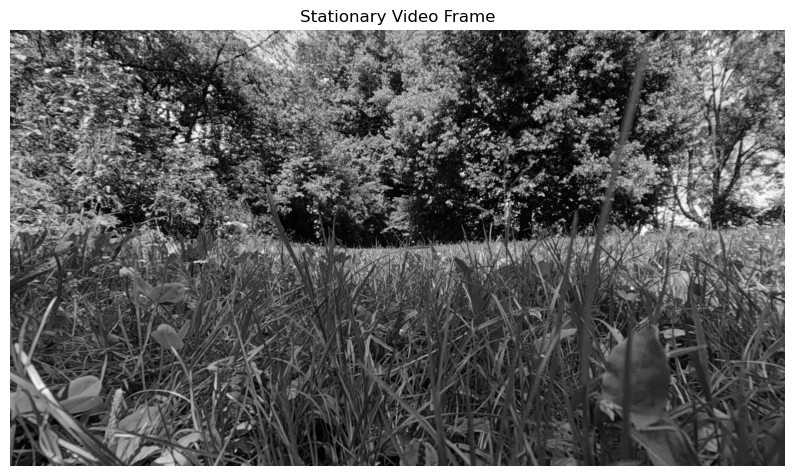

In [35]:
data_group = 'new_nat_videos'
data_dir = "../data/" + data_group + "/"
scene = 'orchard/' # 'forest/'
video_idx_dict= {'1': 0, '10': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}

video_num = 5
frame_idx = 0
video_idx = video_idx_dict[str(video_num)]
fname = data_dir + scene + "stationary_" + str(video_num) + ".MP4"
# load in the video
video_frame = load_frame(fname, frame_idx)
# video = load_video(fname)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(video_frame, cmap='gray', vmin=0, vmax=255)
ax.axis('off')
ax.set_title('Stationary Video Frame')
plt.show()

# save the video frame as a pdf in a new directory called "video_frames"
if not os.path.exists('video_frames'):
    os.makedirs('video_frames')
fig.savefig(f'video_frames/{scene[:-1]}_{video_num}_frame_{frame_idx}.pdf', bbox_inches='tight', pad_inches=0.1, format='pdf')

In [50]:
position_arr += 1

In [51]:
position_arr

array([[-270, -480],
       [-270,    0],
       [-270,  480],
       [   0,  480],
       [   0,    0],
       [   0, -480],
       [ 270,  480],
       [ 270,    0],
       [ 270, -480]])

0.0
400.00000000000006
0.0
0


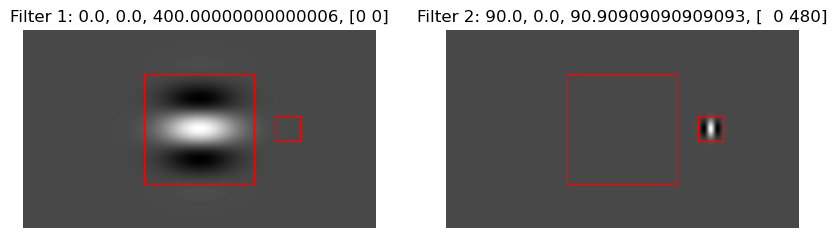

In [67]:
# define the Gabor filter function
def gabor_filter_func(
    sigma, theta, gamma, wavelength, phase, filt_size, x_offset=0, y_offset=0
):
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )
    x = x - x_offset
    y = y + y_offset
    x_prime = x * np.cos(np.pi * theta / 180) + y * np.sin(np.pi * theta / 180)
    y_prime = -x * np.sin(np.pi * theta / 180) + y * np.cos(np.pi * theta / 180)
    filter = np.exp(-0.5 * (x_prime**2 + (gamma * y_prime) ** 2) / sigma**2) * np.cos(
        2 * np.pi * x_prime / wavelength + np.pi * phase / 180)
    filter /= np.linalg.norm(filter)
    return filter

# orientation, phase, wavelength, position
# (16, 4, 3, 9)
# previously used a freq of 0.05 for the low frequency filte
filter1_idx = [0, 0, 3, 4]
filter2_idx = [4, 0, 20, 3]

print(orientation_arr[filter1_idx[0]])
print(wavelength_arr[filter1_idx[2]])
print(phase_arr[filter1_idx[1]])
print(position_arr[filter1_idx[3], 0])

filter1 = gabor_filter_func(
        wavelength_arr[filter1_idx[2]]/3,
        orientation_arr[filter1_idx[0]],
        1,
        wavelength_arr[filter1_idx[2]],
        phase_arr[filter1_idx[1]],
        (resolution_height, resolution_width),
        position_arr[filter1_idx[3], 0],
        -position_arr[filter1_idx[3], 1],
    )

filter2 = gabor_filter_func(
        wavelength_arr[filter2_idx[2]]/3,
        orientation_arr[filter2_idx[0]],
        1,
        wavelength_arr[filter2_idx[2]],
        phase_arr[filter2_idx[1]],
        (resolution_height, resolution_width),
        position_arr[filter2_idx[3], 0],
        -position_arr[filter2_idx[3], 1],
    )

# plot the two filters
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(
    filter1,
    cmap='gray',
)
ax[0].axis('off')
ax[0].set_title(
    f"Filter 1: {orientation_arr[filter1_idx[0]]}, {phase_arr[filter1_idx[1]]}, {wavelength_arr[filter1_idx[2]]}, {position_arr[filter1_idx[3]]}"
)
ax[1].imshow(
    filter2,
    cmap='gray',
)
ax[1].axis('off')
ax[1].set_title(
    f"Filter 2: {orientation_arr[filter2_idx[0]]}, {phase_arr[filter2_idx[1]]}, {wavelength_arr[filter2_idx[2]]}, {position_arr[filter2_idx[3]]}"
)
# create a box around each of the filters
ax[0].add_patch(
    plt.Rectangle(
        (position_arr_og[filter1_idx[3]][1]-3*wavelength_arr[filter1_idx[2]]/4, position_arr_og[filter1_idx[3]][0]-3*wavelength_arr[filter1_idx[2]]/4),
        1.5*wavelength_arr[filter1_idx[2]],
        1.5*wavelength_arr[filter1_idx[2]],
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
ax[0].add_patch(
    plt.Rectangle(
        (position_arr_og[filter2_idx[3]][1]-3*wavelength_arr[filter2_idx[2]]/4, position_arr_og[filter2_idx[3]][0]-3*wavelength_arr[filter2_idx[2]]/4),
        1.5*wavelength_arr[filter2_idx[2]],
        1.5*wavelength_arr[filter2_idx[2]],
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
ax[1].add_patch(
    plt.Rectangle(
        (position_arr_og[filter1_idx[3]][1]-3*wavelength_arr[filter1_idx[2]]/4, position_arr_og[filter1_idx[3]][0]-3*wavelength_arr[filter1_idx[2]]/4),
        1.5*wavelength_arr[filter1_idx[2]],
        1.5*wavelength_arr[filter1_idx[2]],
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
ax[1].add_patch(
    plt.Rectangle(
        (position_arr_og[filter2_idx[3]][1]-3*wavelength_arr[filter2_idx[2]]/4, position_arr_og[filter2_idx[3]][0]-3*wavelength_arr[filter2_idx[2]]/4),
        1.5*wavelength_arr[filter2_idx[2]],
        1.5*wavelength_arr[filter2_idx[2]],
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
plt.show()


0


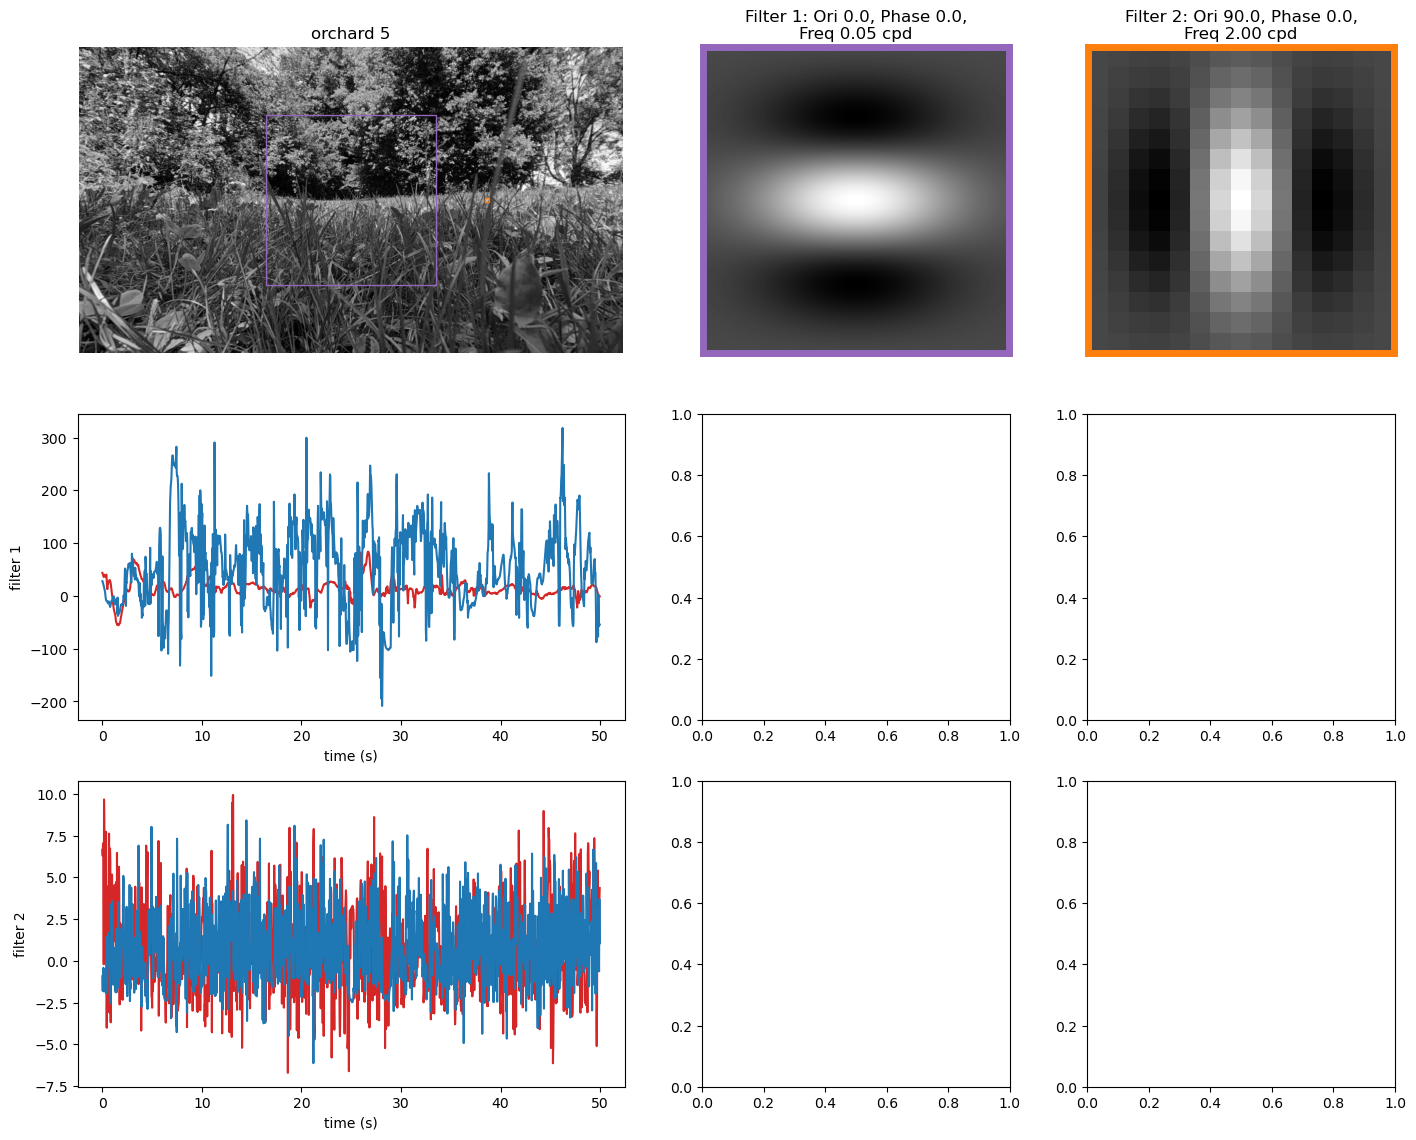

In [91]:
# import fourier transform
from scipy.fft import rfft, rfftfreq

# take subset of filter output for visualization
interval_length = 50*fps
# select a random point in the video
time_idx = 0# np.random.randint(0, vid_length-interval_length)

# define the Gabor filter function
def gabor_filter_func(
    sigma, theta, gamma, wavelength, phase, filt_size, x_offset=0, y_offset=0
):
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )
    x = x - x_offset
    y = y + y_offset
    x_prime = x * np.cos(np.pi * theta / 180) + y * np.sin(np.pi * theta / 180)
    y_prime = -x * np.sin(np.pi * theta / 180) + y * np.cos(np.pi * theta / 180)
    filter = np.exp(-0.5 * (x_prime**2 + (gamma * y_prime) ** 2) / sigma**2) * np.cos(
        2 * np.pi * x_prime / wavelength + np.pi * phase / 180)
    filter /= np.linalg.norm(filter)
    return filter

# orientation, phase, surround_distance, displacement
# (16, 4, 3, 9)
filter1_idx = [0, 0, 3, 4]
filter2_idx = [4, 0, 35, 3]

filter1 = gabor_filter_func(
        wavelength_arr[filter1_idx[2]]/3,
        orientation_arr[filter1_idx[0]],
        1,
        wavelength_arr[filter1_idx[2]],
        phase_arr[filter1_idx[1]],
        (resolution_height, resolution_width),
        position_arr[filter1_idx[3], 0],
        -position_arr[filter1_idx[3], 1],
    )

filter2 = gabor_filter_func(
        wavelength_arr[filter2_idx[2]]/3,
        orientation_arr[filter2_idx[0]],
        1,
        wavelength_arr[filter2_idx[2]],
        phase_arr[filter2_idx[1]],
        (resolution_height, resolution_width),
        position_arr[filter2_idx[3], 0],
        -position_arr[filter2_idx[3], 1],
    )

fig, ax = plt.subplots(3, 3, figsize=(8+4.5+4.5, 3*4.5), width_ratios=[8, 4.5, 4.5])
ax[0, 0].imshow(video_frame, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].add_patch(
    plt.Rectangle(
        (position_arr_og[filter1_idx[3]][1]-3*wavelength_arr[filter1_idx[2]]/4, position_arr_og[filter1_idx[3]][0]-3*wavelength_arr[filter1_idx[2]]/4),
        1.5*wavelength_arr[filter1_idx[2]],
        1.5*wavelength_arr[filter1_idx[2]],
        linewidth=1,
        edgecolor='tab:purple',
        facecolor='none',
    )
)
ax[0, 0].add_patch(
    plt.Rectangle(
        (position_arr_og[filter2_idx[3]][1]-3*wavelength_arr[filter2_idx[2]]/4, position_arr_og[filter2_idx[3]][0]-3*wavelength_arr[filter2_idx[2]]/4),
        1.5*wavelength_arr[filter2_idx[2]],
        1.5*wavelength_arr[filter2_idx[2]],
        linewidth=1,
        edgecolor='tab:orange',
        facecolor='none',
    )
)
ax[0, 0].set_title(f'{scene[:-1]} {video_num}')
ax[0, 1].imshow(filter1, cmap='gray')
# make the outline blue without adding patch
ax[0, 1].axis()
for spine in ax[0, 1].spines.values():
    spine.set_edgecolor('tab:purple')
    spine.set_linewidth(5)
print(position_arr[filter1_idx[3], 1])
ax[0, 1].set_xlim(
    resolution_width//2-1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 1],
    resolution_width//2+1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 1]
)
ax[0, 1].set_ylim(
    resolution_height//2-1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 0],
    resolution_height//2+1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 0],
)
ax[0, 2].set_xlim(
    resolution_width//2-1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 1],
    resolution_width//2+1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 1],
)
ax[0, 2].set_ylim(
    resolution_height//2-1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 0],
    resolution_height//2+1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 0],
)
ax[0, 2].imshow(filter2, cmap='gray')
for spine in ax[0, 2].spines.values():
    spine.set_edgecolor('tab:orange')
    spine.set_linewidth(5)
# remove ticks and labels
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])
ax[0, 2].set_title(
    f"Filter 2: Ori {orientation_arr[filter2_idx[0]]}, Phase {phase_arr[filter2_idx[1]]},\nFreq {freq_arr[filter2_idx[2]]:.2f} cpd"
)
ax[0, 1].set_title(
    f"Filter 1: Ori {orientation_arr[filter1_idx[0]]}, Phase {phase_arr[filter1_idx[1]]},\nFreq {freq_arr[filter1_idx[2]]:.2f} cpd"
)

# in the second row, plot the output of filter 1 in the first column, the temporal spectrum of filter 1 in the second column, and the output of filter1 and filter2 in the third column
ax[1, 0].plot(np.arange(0, vid_length/fps, 1/fps), stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :], color='tab:red') 
ax[1, 0].plot(np.arange(0, vid_length/fps, 1/fps), moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :], color='tab:blue')
ax[1, 0].set_xlabel('time (s)')
ax[1, 0].set_ylabel('filter 1')

ax[2, 0].plot(np.arange(0, vid_length/fps, 1/fps), stationary_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], :], color='tab:red')
ax[2, 0].plot(np.arange(0, vid_length/fps, 1/fps), moving_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], :], color='tab:blue')
ax[2, 0].set_xlabel('time (s)')
ax[2, 0].set_ylabel('filter 2')

plt.show()

# Repeat for all pairs

In [100]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
import matplotlib.colors as mcolors

# --- Fixed parameters for each filter ---
wavelength1_idx = 3   # filter 1 wavelength index
position1_idx = 4     # filter 1 position index
wavelength2_idx = 35   # filter 2 wavelength index
position2_idx = 3     # filter 2 position index

fps = 30
window_length = 5 * fps
norm1 = mcolors.CenteredNorm(halfrange=0.003)
norm2 = mcolors.CenteredNorm(halfrange=0.1)
output_dir = "figure5_5sec_orchard_demean_norm"
os.makedirs(output_dir, exist_ok=True)

for ori1 in range(len(orientation_arr)):
    for phase1 in range(len(phase_arr)):
        for ori2 in range(len(orientation_arr)):
            for phase2 in range(len(phase_arr)):
                if not (ori1 == ori2 or phase1 == phase2):
                    continue

                filter1_idx = [ori1, phase1, wavelength1_idx, position1_idx]
                filter2_idx = [ori2, phase2, wavelength2_idx, position2_idx]

                # Generate Gabor filters
                filter1 = gabor_filter_func(
                        wavelength_arr[filter1_idx[2]]/3,
                        orientation_arr[filter1_idx[0]],
                        1,
                        wavelength_arr[filter1_idx[2]],
                        phase_arr[filter1_idx[1]],
                        (resolution_height, resolution_width),
                        position_arr[filter1_idx[3], 0],
                        -position_arr[filter1_idx[3], 1],
                    )
                
                filter2 = gabor_filter_func(
                        wavelength_arr[filter2_idx[2]]/3,
                        orientation_arr[filter2_idx[0]],
                        1,
                        wavelength_arr[filter2_idx[2]],
                        phase_arr[filter2_idx[1]],
                        (resolution_height, resolution_width),
                        position_arr[filter2_idx[3], 0],
                        -position_arr[filter2_idx[3], 1],
                    )

                # Select a random time point
                time_idx = np.random.randint(0, vid_length - window_length)

                # Prepare filter outputs
                stat_stim_norm = stationary_stim[video_idx, ori1, phase1, wavelength1_idx, position1_idx, time_idx:time_idx+window_length].copy()
                mov_stim_norm = moving_stim[video_idx, ori1, phase1, wavelength1_idx, position1_idx, time_idx:time_idx+window_length].copy()
                stat_stim_norm -= np.mean(stat_stim_norm)
                mov_stim_norm -= np.mean(mov_stim_norm)

                stat_stim_norm2 = stationary_stim[video_idx, ori2, phase2, wavelength2_idx, position2_idx, time_idx:time_idx+window_length].copy()
                mov_stim_norm2 = moving_stim[video_idx, ori2, phase2, wavelength2_idx, position2_idx, time_idx:time_idx+window_length].copy()
                stat_stim_norm2 -= np.mean(stat_stim_norm2)
                mov_stim_norm2 -= np.mean(mov_stim_norm2)

                # Plotting (matching Part 1)
                fig, ax = plt.subplots(3, 3, figsize=(8+4.5+4.5, 3*4.5), width_ratios=[8, 4.5, 4.5])
                # Video frame with rectangles
                ax[0, 0].imshow(video_frame, cmap='gray', vmin=0, vmax=255)
                ax[0, 0].axis('off')
                ax[0, 0].add_patch(
                    plt.Rectangle(
                        (position_arr_og[filter1_idx[3]][1]-3*wavelength_arr[filter1_idx[2]]/4, position_arr_og[filter1_idx[3]][0]-3*wavelength_arr[filter1_idx[2]]/4),
                        1.5*wavelength_arr[filter1_idx[2]],
                        1.5*wavelength_arr[filter1_idx[2]],
                        linewidth=2,
                        edgecolor='tab:green',
                        facecolor='none',
                    )
                )
                ax[0, 0].add_patch(
                    plt.Rectangle(
                        (position_arr_og[filter2_idx[3]][1]-3*wavelength_arr[filter2_idx[2]]/4, position_arr_og[filter2_idx[3]][0]-3*wavelength_arr[filter2_idx[2]]/4),
                        1.5*wavelength_arr[filter2_idx[2]],
                        1.5*wavelength_arr[filter2_idx[2]],
                        linewidth=2,
                        edgecolor='tab:olive',
                        facecolor='none',
                    )
                )
                ax[0, 0].set_title(f'{scene[:-1]} {video_num}')

                # Filter 1
                ax[0, 1].imshow(filter1, cmap='gray', norm=norm)
                for spine in ax[0, 1].spines.values():
                    spine.set_edgecolor('tab:green')
                    spine.set_linewidth(5)
                ax[0, 1].set_xlim(
                    resolution_width//2-1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 1],
                    resolution_width//2+1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 1]
                )
                ax[0, 1].set_ylim(
                    resolution_height//2-1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 0],
                    resolution_height//2+1.5*wavelength_arr[filter1_idx[2]]/2+position_arr[filter1_idx[3], 0],
                )

                ax[0, 1].set_xticks([])
                ax[0, 1].set_yticks([])
                ax[0, 1].set_title(
                    f"Filter 1: Ori {orientation_arr[ori1]}, Phase {phase_arr[phase1]},\nFreq {freq_arr[wavelength1_idx]:.2f} cpd"
                )

                # Filter 2
                ax[0, 2].imshow(filter2, cmap='gray', norm=norm2)
                for spine in ax[0, 2].spines.values():
                    spine.set_edgecolor('tab:olive')
                    spine.set_linewidth(5)
                ax[0, 2].set_xlim(
                    resolution_width//2-1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 1],
                    resolution_width//2+1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 1],
                )
                ax[0, 2].set_ylim(
                    resolution_height//2-1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 0],
                    resolution_height//2+1.5*wavelength_arr[filter2_idx[2]]/2+position_arr[filter2_idx[3], 0],
                )
                ax[0, 2].set_xticks([])
                ax[0, 2].set_yticks([])
                ax[0, 2].set_title(
                    f"Filter 2: Ori {orientation_arr[ori2]}, Phase {phase_arr[phase2]},\nFreq {freq_arr[wavelength2_idx]:.2f} cpd"
                )

                # Filter 1 output (stationary & moving)
                ax[1, 0].plot(np.arange(0, window_length / fps, 1 / fps), stat_stim_norm, color='tab:gray')
                ax[1, 0].plot(np.arange(0, window_length / fps, 1 / fps), mov_stim_norm, color='tab:orange')
                ax[1, 0].set_xlabel('time (s)')
                ax[1, 0].set_ylabel('filter 1')

                # Filter 2 output (stationary & moving)
                ax[2, 0].plot(np.arange(0, window_length / fps, 1 / fps), stat_stim_norm2, color='tab:gray')
                ax[2, 0].plot(np.arange(0, window_length / fps, 1 / fps), mov_stim_norm2, color='tab:orange')
                ax[2, 0].set_xlabel('time (s)')
                ax[2, 0].set_ylabel('filter 2')

                # Save figure
                filename = f"ori{ori1}_phase{phase1}_ori{ori2}_phase{phase2}.pdf"
                filepath = os.path.join(output_dir, filename)
                plt.tight_layout()
                plt.savefig(filepath)
                plt.close(fig)